## L24 Fixed Effects and First-Differences in Panel Data Analysis: The effect of measles immunization on child survival

In [1]:
import os
import sys
import warnings
from datetime import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from IPython.core.display import HTML
from plotnine import *
from stargazer.stargazer import Stargazer

warnings.filterwarnings("ignore")


In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/worldbank-immunization/clean/"
data_out = dirname + "da_case_studies/ch23-immunization-life/"
output = dirname + "da_case_studies/ch23-immunization-life/output/"

func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


In [3]:
# Import the prewritten helper functions
from py_helper_functions import *


In [4]:
# Import data

data = pd.read_csv("worldbank-immunization-continents.csv")


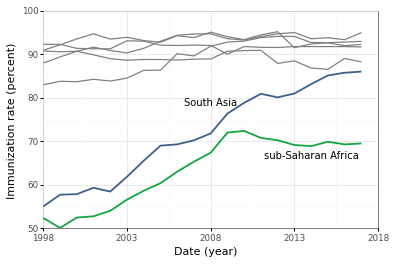

<ggplot: (8790044867361)>

In [5]:
p1 = (
    ggplot(data, aes(x="year", y="imm_SAS"))
    + geom_line(color=color[0], size=1)
    + geom_line(aes(x="year", y="imm_SSF"), color=color[1], size=1)
    + annotate(
        geom="text",
        x=data.loc[12, "year"] - 2,
        y=data.loc[12, "imm_SAS"],
        label="South Asia",
        size=10,
    )
    + annotate(
        geom="text",
        x=data.loc[16, "year"],
        y=data.loc[16, "imm_SSF"] - 2,
        label="sub-Saharan Africa",
        size=10,
    )
    + labs(y="Immunization rate (percent)", x="Date (year)")
    + scale_y_continuous(expand=(0, 0), breaks=seq(50, 100, 10), limits=(50, 100))
    + scale_x_continuous(
        expand=(0, 0), breaks=seq(1998, 2018, 5), limits=(1998, 2018)
    )
    + theme_bw()
)

for col in data.columns[1:6]:
    p1 += geom_line(aes(x="year", y=col), color="grey", size=0.7)

p1


In [6]:
for col in data.columns[8:]:
    data[col] = data[col] / 10


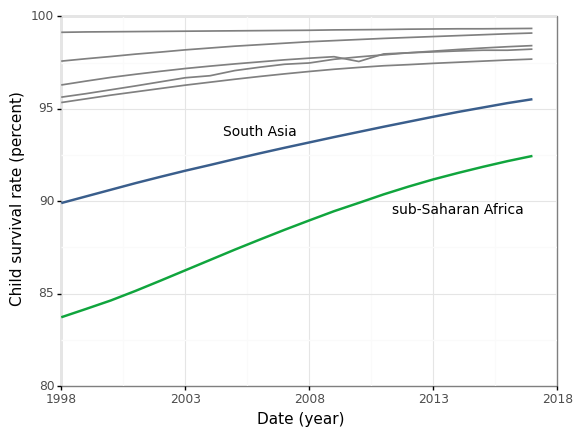

<ggplot: (8790095447461)>

In [7]:
p2 = (
    ggplot(data, aes(x="year", y="surv_SAS"))
    + geom_line(color=color[0], size=1)
    + geom_line(aes(x="year", y="surv_SSF"), color=color[1], size=1)
    + annotate(
        geom="text",
        x=data.loc[12, "year"] - 4,
        y=data.loc[12, "surv_SAS"],
        label="South Asia",
        size=10,
    )
    + annotate(
        geom="text",
        x=data.loc[16, "year"],
        y=data.loc[16, "surv_SSF"] - 2,
        label="sub-Saharan Africa",
        size=10,
    )
    + labs(y="Child survival rate (percent)", x="Date (year)")
    + scale_y_continuous(expand=(0, 0), breaks=seq(80, 100, 5), limits=(80, 100))
    + scale_x_continuous(
        expand=(0, 0), breaks=range(1998, 2019, 5), limits=(1998, 2018)
    )
    + theme_bw()
)

for col in data.columns[8:13]:
    p2 += geom_line(aes(x="year", y=col), color="grey", size=0.7)

p2


# Regressions on countries


In [9]:
data_panel = pd.read_csv("worldbank-immunization-panel.csv")
data_panel.describe()

,year,pop,mort,surv,imm,gdppc,lngdppc,hexp
count,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3642.000000,3642.000000,3165.000000
mean,2007.526924,35.067473,42.982847,95.701715,85.298135,16337.051802,9.042446,6.274914
std,5.759522,132.455594,45.517445,4.551744,15.738758,19070.325200,1.234401,2.878283
min,1998.000000,0.009332,2.100000,75.720000,8.000000,275.518093,5.618653,1.024978
25%,2003.000000,1.756771,9.300000,93.425000,79.000000,3114.288251,8.043756,4.321824
50%,2008.000000,7.395599,23.300000,97.670000,92.000000,9386.069679,9.146982,5.766445
75%,2013.000000,23.576856,65.750000,99.070000,96.000000,22449.101714,10.019005,7.916312
max,2017.000000,1386.395000,242.800000,99.790000,99.000000,124024.568165,11.728235,27.417822


In [12]:
data_panel = data_panel.dropna(subset=["imm", "gdppc"])

In [13]:
data_panel["balanced"] = data_panel["c"].isin(
    data_panel.groupby("c")
    .agg(
        min_year=("year", min), max_year=("year", max), n_unique_years=("year", "count")
    )
    .query("(min_year == 1998)&(max_year == 2017)&(n_unique_years==20)")
    .index
)


In [14]:
data_balanced = data_panel.query("balanced == True")


In [15]:
data_panel = data_panel.dropna(subset=["imm", "gdppc"])
data_panel["balanced"] = data_panel["c"].isin(
    data_panel.groupby("c")
    .agg(
        min_year=("year", min), max_year=("year", max), n_unique_years=("year", "count")
    )
    .query("(min_year == 1998)&(max_year == 2017)&(n_unique_years==20)")
    .index
)
data_balanced = data_panel.query("balanced == True")
countries_grouped = data_balanced.groupby("c")

data_balanced["lnpop"] = countries_grouped["pop"].transform(np.log)
data_balanced["d_surv"] = countries_grouped["surv"].transform("diff")
data_balanced["d_imm"] = countries_grouped["imm"].transform("diff")
data_balanced["d2_imm"] = countries_grouped["d_imm"].transform("diff")
data_balanced["d_lngdppc"] = countries_grouped["lngdppc"].transform("diff")
data_balanced["d_lnpop"] = countries_grouped["lnpop"].transform("diff")
data_balanced["avgpop"] = countries_grouped["pop"].transform("mean")

data_balanced = data_balanced.sort_values(by=["c", "year"])


## Fixed Effect

In [17]:
pip install linearmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 91.5 kB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 988.1/988.1 kB 96.5 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 163.1 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.13
    Uninstalling Cython-0.29.13:
      Successfully uninstalled Cython-0.29.13
Note: you may need to restart the kernel to use updated packages.


In [18]:
from linearmodels import PanelOLS

In [19]:
data_balanced = data_balanced.assign(
    Year=lambda x: x["year"].astype("category")
).set_index(["c", "year"])

In [30]:
fe_lm = PanelOLS.from_formula(
    "surv ~ imm + year + EntityEffects",
    data_balanced,
    weights=data_balanced["avgpop"],
).fit(cov_type="clustered", cluster_entity=True)


KeyError: 'This `Formula` instance does not have structure @ `1`.'

In [31]:
from linearmodels import PanelOLS

# Create the formula without the EntityEffects term
formula = "surv ~ imm + year"

# Convert the "year" column to a categorical variable
data_balanced["year"] = data_balanced["year"].astype("category")

# Set the index of the DataFrame
data_balanced = data_balanced.set_index(["c", "year"])

# Create the PanelOLS model using the corrected formula and DataFrame
fe_lm = PanelOLS.from_formula(formula, data_balanced, weights=data_balanced["avgpop"])

# Fit the model with clustered standard errors
fe_lm = fe_lm.fit(cov_type="clustered", cluster_entity=True)


KeyError: 'year'

In [21]:
fe_lm.summary


NameError: name 'fe_lm' is not defined

In [17]:
# within R2
fe_lm.rsquared_within


0.7172189726881081

In [18]:
fe_lm2 = PanelOLS.from_formula(
    "surv ~ imm + lngdppc + lnpop + Year + EntityEffects",
    data_balanced,
    weights=data_balanced["avgpop"],
).fit(cov_type="clustered", cluster_entity=True)


In [19]:
fe_lm2.summary


Dep. Variable:,surv,R-squared:,0.8484
Estimator:,PanelOLS,R-squared (Between):,-31.327
No. Observations:,3440,R-squared (Within):,0.8484
Date:,"Mon, Oct 03 2022",R-squared (Overall):,-26.671
Time:,13:38:47,Log-likelihood,-2981.3
Cov. Estimator:,Clustered,,
,,F-statistic:,2.826e+06
Entities:,172,P-value,0.0000
Avg Obs:,20.000,Distribution:,"F(22,3246)"
Min Obs:,20.000,,
Max Obs:,20.000,F-statistic (robust):,1.499e+09


In [20]:
# within R2
fe_lm2.rsquared_within


0.8483654071512511

In [21]:
# no weights, not in book
fe_lm2_nowts = PanelOLS.from_formula(
    "surv ~ imm + lngdppc + lnpop + Year + EntityEffects",
    data_balanced,
).fit(cov_type="clustered", cluster_entity=True)
fe_lm2_nowts


Dep. Variable:,surv,R-squared:,0.6151
Estimator:,PanelOLS,R-squared (Between):,-15.038
No. Observations:,3440,R-squared (Within):,0.6151
Date:,"Mon, Oct 03 2022",R-squared (Overall):,-13.209
Time:,13:38:48,Log-likelihood,-4664.9
Cov. Estimator:,Clustered,,
,,F-statistic:,235.79
Entities:,172,P-value,0.0000
Avg Obs:,20.000,Distribution:,"F(22,3246)"
Min Obs:,20.000,,
Max Obs:,20.000,F-statistic (robust):,2.756e+08


In [22]:
# large difference in R2
print(fe_lm2_nowts.rsquared_within)
print(fe_lm2.rsquared_within)


0.6151025994954724
0.8483654071512511


In [23]:
# CLUSTER SE VS BIASED SE

fe_lm3 = PanelOLS.from_formula(
    "surv ~ imm + lngdppc + lnpop + Year + EntityEffects",
    data_balanced,
    weights=data_balanced["avgpop"],
).fit(cov_type="robust")


In [24]:
fe_lm3


Dep. Variable:,surv,R-squared:,0.8484
Estimator:,PanelOLS,R-squared (Between):,-31.327
No. Observations:,3440,R-squared (Within):,0.8484
Date:,"Mon, Oct 03 2022",R-squared (Overall):,-26.671
Time:,13:38:48,Log-likelihood,-2981.3
Cov. Estimator:,Robust,,
,,F-statistic:,2.826e+06
Entities:,172,P-value,0.0000
Avg Obs:,20.000,Distribution:,"F(22,3246)"
Min Obs:,20.000,,
Max Obs:,20.000,F-statistic (robust):,3.164e+06


## First Difference

In [25]:
data_balanced = data_balanced.reset_index()
data_balanced["year"] = data_balanced["year"].astype("category")


In [26]:
# Basic fd
model = smf.wls("d_surv ~ d_imm", data_balanced, weights=data_balanced["pop"])
fd_lm = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data_balanced.loc[model.data.row_labels, "c"]},
)
fd_lm.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 d_surv   R-squared:                       0.013
Model:                            WLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     12.53
Date:                Mon, 03 Oct 2022   Prob (F-statistic):           0.000515
Time:                        13:38:48   Log-Likelihood:                -2984.5
No. Observations:                3268   AIC:                             5973.
Df Residuals:                    3266   BIC:                             5985.
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1885      0.024      7.702      0.000       0.141       0.236
d_imm          0.0086      0.002      3.540      0.000       0.004       0.013
==============================================================================
Omnibus:                     1714.815   Durbin-Watson:                   1.730
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         15867835.538
Skew:                           0.518   Prob(JB):                         0.00
Kurtosis:                     344.367   Cond. No.                         3.44
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [27]:
# FD, 5 lags
model = smf.wls(
    "d_surv ~ d_imm.shift(0) + d_imm.shift(1) + d_imm.shift(2) + d_imm.shift(3) + d_imm.shift(4) + d_imm.shift(5)",
    data_balanced,
    weights=data_balanced["pop"],
)
fd_lm_5 = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data_balanced.loc[model.data.row_labels, "c"]},
)
fd_lm_5.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 d_surv   R-squared:                       0.078
Model:                            WLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     8.170
Date:                Mon, 03 Oct 2022   Prob (F-statistic):           8.90e-08
Time:                        13:38:48   Log-Likelihood:                -2235.1
No. Observations:                2408   AIC:                             4484.
Df Residuals:                    2401   BIC:                             4525.
Df Model:                           6                                         
Covariance Type:              cluster                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1361      0.018      7.532      0.000       0.101       0.172
d_imm.shift(0)     0.0099      0.002      5.310      0.000       0.006       0.014
d_imm.shift(1)     0.0100      0.002      5.833      0.000       0.007       0.013
d_imm.shift(2)     0.0111      0.002      4.747      0.000       0.007       0.016
d_imm.shift(3)     0.0092      0.002      4.672      0.000       0.005       0.013
d_imm.shift(4)     0.0069      0.002      3.768      0.000       0.003       0.010
d_imm.shift(5)     0.0059      0.002      3.421      0.001       0.003       0.009
==============================================================================
Omnibus:                     1246.475   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         16509408.542
Skew:                           0.341   Prob(JB):                         0.00
Kurtosis:                     408.642   Cond. No.                         4.69
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [28]:
# FD, 5 lags, cumul

model = smf.wls(
    "d_surv ~ d_imm.shift(5) + d2_imm.shift(0) + d2_imm.shift(1) + d2_imm.shift(2) + d2_imm.shift(3) + d2_imm.shift(4)",
    data_balanced,
    weights=data_balanced["pop"],
)
fd_lm_5_cumul = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data_balanced.loc[model.data.row_labels, "c"]},
)
fd_lm_5_cumul.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 d_surv   R-squared:                       0.078
Model:                            WLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     8.170
Date:                Mon, 03 Oct 2022   Prob (F-statistic):           8.90e-08
Time:                        13:38:48   Log-Likelihood:                -2235.1
No. Observations:                2408   AIC:                             4484.
Df Residuals:                    2401   BIC:                             4525.
Df Model:                           6                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1361      0.018      7.532      0.000       0.101       0.172
d_imm.shift(5)      0.0529      0.010      5.496      0.000       0.034       0.072
d2_imm.shift(0)     0.0099      0.002      5.310      0.000       0.006       0.014
d2_imm.shift(1)     0.0199      0.003      5.878      0.000       0.013       0.026
d2_imm.shift(2)     0.0309      0.005      5.912      0.000       0.021       0.041
d2_imm.shift(3)     0.0401      0.007      6.010      0.000       0.027       0.053
d2_imm.shift(4)     0.0470      0.008      5.813      0.000       0.031       0.063
==============================================================================
Omnibus:                     1246.475   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         16509408.542
Skew:                           0.341   Prob(JB):                         0.00
Kurtosis:                     408.642   Cond. No.                         8.89
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [29]:
# FD, 5 lags, cumul, lead

fd_lm_5_cumul_lead_formula = "d_surv ~ d_imm.shift(5) + d2_imm.shift(0) + \
d2_imm.shift(1) + d2_imm.shift(2) + d2_imm.shift(3) + \
d2_imm.shift(4) + d_imm.shift(-1) + d_imm.shift(-2) + d_imm.shift(-3)"

model = smf.wls(
    fd_lm_5_cumul_lead_formula,
    data_balanced,
    weights=data_balanced["pop"],
)

fd_lm_5_cumul_lead = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data_balanced.loc[model.data.row_labels, "c"]},
)


In [30]:
fd_lm_5_cumul_lead.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 d_surv   R-squared:                       0.093
Model:                            WLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     12.30
Date:                Mon, 03 Oct 2022   Prob (F-statistic):           6.48e-15
Time:                        13:38:48   Log-Likelihood:                -1937.3
No. Observations:                1892   AIC:                             3895.
Df Residuals:                    1882   BIC:                             3950.
Df Model:                           9                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1245      0.018      6.960      0.000       0.089       0.160
d_imm.shift(5)      0.0543      0.008      6.839      0.000       0.039       0.070
d2_imm.shift(0)     0.0109      0.002      7.213      0.000       0.008       0.014
d2_imm.shift(1)     0.0207      0.003      7.985      0.000       0.016       0.026
d2_imm.shift(2)     0.0317      0.005      6.709      0.000       0.022       0.041
d2_imm.shift(3)     0.0402      0.006      6.977      0.000       0.029       0.051
d2_imm.shift(4)     0.0471      0.007      6.943      0.000       0.034       0.060
d_imm.shift(-1)     0.0084      0.002      5.312      0.000       0.005       0.012
d_imm.shift(-2)     0.0074      0.002      3.583      0.000       0.003       0.011
d_imm.shift(-3)     0.0050      0.003      1.920      0.055      -0.000       0.010
==============================================================================
Omnibus:                      975.559   Durbin-Watson:                   2.296
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10903619.758
Skew:                           0.329   Prob(JB):                         0.00
Kurtosis:                     374.903   Cond. No.                         9.30
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

___

### AGGREG TREND, CONFOUNDERS, CTRY TRENDS

In [31]:
# FD, 5 lags, cumul, aggreg trend

fd_lm_5_cumul_trend_formula = "d_surv ~ d_imm.shift(5) + d2_imm.shift(0) + d2_imm.shift(1) + \
d2_imm.shift(2) + d2_imm.shift(3) + d2_imm.shift(4) + year"

model = smf.wls(
    fd_lm_5_cumul_trend_formula,
    data_balanced,
    weights=data_balanced["pop"],
)

fd_lm_5_cumul_trend = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data_balanced.loc[model.data.row_labels, "c"]},
)

fd_lm_5_cumul_trend.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 d_surv   R-squared:                       0.088
Model:                            WLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     39.66
Date:                Mon, 03 Oct 2022   Prob (F-statistic):           1.17e-53
Time:                        13:38:49   Log-Likelihood:                -2221.0
No. Observations:                2408   AIC:                             4482.
Df Residuals:                    2388   BIC:                             4598.
Df Model:                          19                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1280      0.017      7.342      0.000       0.094       0.162
year[T.1999]    -2.764e-17    6.5e-18     -4.251      0.000   -4.04e-17   -1.49e-17
year[T.2000]     1.003e-19   8.48e-18      0.012      0.991   -1.65e-17    1.67e-17
year[T.2001]    -8.467e-19   1.41e-17     -0.060      0.952   -2.85e-17    2.68e-17
year[T.2002]     2.276e-18   1.08e-17      0.211      0.833   -1.89e-17    2.34e-17
year[T.2003]      1.71e-17   9.57e-18      1.787      0.074   -1.65e-18    3.59e-17
year[T.2004]        0.0458      0.031      1.465      0.143      -0.015       0.107
year[T.2005]        0.0814      0.026      3.175      0.002       0.031       0.132
year[T.2006]        0.0304      0.008      3.901      0.000       0.015       0.046
year[T.2007]        0.0261      0.007      3.814      0.000       0.013       0.039
year[T.2008]       -0.0137      0.019     -0.735      0.463      -0.050       0.023
year[T.2009]        0.0085      0.023      0.363      0.717      -0.037       0.054
year[T.2010]       -0.0316      0.022     -1.437      0.151      -0.075       0.012
year[T.2011]        0.0056      0.025      0.222      0.824      -0.044       0.055
year[T.2012]       -0.0051      0.006     -0.876      0.381      -0.017       0.006
year[T.2013]       -0.0044      0.006     -0.780      0.436      -0.015       0.007
year[T.2014]        0.0001      0.006      0.019      0.985      -0.012       0.013
year[T.2015]     8.965e-06      0.009      0.001      0.999      -0.018       0.018
year[T.2016]       -0.0042      0.011     -0.391      0.696      -0.025       0.017
year[T.2017]       -0.0108      0.010     -1.046      0.296      -0.031       0.009
d_imm.shift(5)      0.0525      0.010      5.051      0.000       0.032       0.073
d2_imm.shift(0)     0.0091      0.002      4.868      0.000       0.005       0.013
d2_imm.shift(1)     0.0183      0.004      5.067      0.000       0.011       0.025
d2_imm.shift(2)     0.0294      0.005      5.425      0.000       0.019       0.040
d2_imm.shift(3)     0.0387      0.007      5.340      0.000       0.024       0.053
d2_imm.shift(4)     0.0462      0.009      5.350      0.000       0.029       0.063
==============================================================================
Omnibus:                     1257.052   Durbin-Watson:                   2.160
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         17077360.415
Skew:                           0.373   Prob(JB):                         0.00
Kurtosis:                     415.560   Cond. No.                     1.45e+16
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The smallest eigenvalue is 1.58e-26. This might indicate that there are
strong multicollinearity 

In [32]:
# *FD, 5 lags, cumul, aggreg trend, confounders

fd_lm_5_cumul_trend_c_formula = (
    "d_surv ~ d_imm.shift(5) + "
    + " + ".join(["d2_imm.shift({i})".format(i=i) for i in range(0, 5)])
    + " + "
    + " + ".join(["d_lngdppc.shift({i})".format(i=i) for i in range(0, 6)])
    + " + "
    + " + ".join(["d_lnpop.shift({i})".format(i=i) for i in range(0, 6)])
    + " + year"
)


In [33]:
model = smf.wls(
    fd_lm_5_cumul_trend_c_formula,
    data_balanced,
    weights=data_balanced["pop"],
)

fd_lm_5_cumul_trend_c = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data_balanced.loc[model.data.row_labels, "c"]},
)

fd_lm_5_cumul_trend_c.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 d_surv   R-squared:                       0.212
Model:                            WLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     65.51
Date:                Mon, 03 Oct 2022   Prob (F-statistic):           9.04e-80
Time:                        13:38:49   Log-Likelihood:                -2046.1
No. Observations:                2408   AIC:                             4156.
Df Residuals:                    2376   BIC:                             4341.
Df Model:                          31                                         
Covariance Type:              cluster                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0311      0.020     -1.520      0.128      -0.071       0.009
year[T.1999]        3.261e-14   1.65e-14      1.975      0.048    2.56e-16     6.5e-14
year[T.2000]        1.912e-14   6.64e-15      2.877      0.004    6.09e-15    3.21e-14
year[T.2001]       -4.549e-15   1.06e-14     -0.429      0.668   -2.53e-14    1.63e-14
year[T.2002]       -3.157e-14   9.66e-15     -3.269      0.001   -5.05e-14   -1.26e-14
year[T.2003]        1.295e-14   3.28e-15      3.942      0.000    6.51e-15    1.94e-14
year[T.2004]           0.0229      0.029      0.785      0.432      -0.034       0.080
year[T.2005]           0.0642      0.026      2.499      0.012       0.014       0.115
year[T.2006]           0.0110      0.010      1.147      0.251      -0.008       0.030
year[T.2007]           0.0042      0.008      0.510      0.610      -0.012       0.021
year[T.2008]          -0.0126      0.021     -0.605      0.545      -0.053       0.028
year[T.2009]           0.0110      0.026      0.421      0.674      -0.040       0.062
year[T.2010]          -0.0536      0.033     -1.631      0.103      -0.118       0.011
year[T.2011]           0.0123      0.030      0.404      0.686      -0.047       0.072
year[T.2012]          -0.0087      0.006     -1.411      0.158      -0.021       0.003
year[T.2013]          -0.0146      0.007     -2.077      0.038      -0.028      -0.001
year[T.2014]          -0.0106      0.008     -1.406      0.160      -0.025       0.004
year[T.2015]          -0.0143      0.008     -1.709      0.087      -0.031       0.002
year[T.2016]          -0.0176      0.010     -1.769      0.077      -0.037       0.002
year[T.2017]          -0.0247      0.010     -2.429      0.015      -0.045      -0.005
d_imm.shift(5)         0.0297      0.009      3.360      0.001       0.012       0.047
d2_imm.shift(0)        0.0057      0.001      4.202      0.000       0.003       0.008
d2_imm.shift(1)        0.0107      0.003      3.826      0.000       0.005       0.016
d2_imm.shift(2)        0.0179      0.004      4.143      0.000       0.009       0.026
d2_imm.shift(3)        0.0231      0.006      3.840      0.000       0.011       0.035
d2_imm.shift(4)        0.0268      0.007      3.703      0.000       0.013       0.041
d_lngdppc.shift(0)     0.7828      0.447      1.752      0.080      -0.093       1.659
d_lngdppc.shift(1)    -0.2928      0.454     -0.645      0.519      -1.182       0.596
d_lngdppc.shift(2)     0.2325      0.152      1.527      0.127      -0.066       0.531
d_lngdppc.shift(3)     0.2818      0.105      2.697      0.007       0.077       0.487
d_lngdppc.shift(4)     0.0957      0.132      0.724      0.469      -0.164       0.355
d_lngdppc.shift(5)     0.1929      0.138      1.401      0.161      -0.077       0.463
d_lnpop.shift(0)       8.7829      2.6

In [34]:
# * check: cumulative coeffs on the confounders


In [35]:
hypotheses = (
    " + ".join(["d_lngdppc.shift({i})".format(i=i) for i in range(0, 6)]) + " = 0"
)
f_test = fd_lm_5_cumul_trend_c.f_test(hypotheses)

print(f_test)


<F test: F=12.07461529483102, p=0.0006477451801072691, df_denom=171, df_num=1>


In [36]:
hypotheses = (
    " + ".join(["d_lnpop.shift({i})".format(i=i) for i in range(0, 6)]) + " = 0"
)
f_test = fd_lm_5_cumul_trend_c.f_test(hypotheses)

print(f_test)


<F test: F=54.11448822337828, p=7.540868463691176e-12, df_denom=171, df_num=1>


In [37]:
# * check: it's not the number of obsrevations


In [38]:
data_balanced_filtered = data_balanced.dropna(subset=["d_lngdppc"])


In [39]:
model = smf.wls(
    fd_lm_5_cumul_trend_formula,
    data_balanced_filtered,
    weights=data_balanced_filtered["pop"],
)

fd_lm_5_cumul_trend2 = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data_balanced_filtered.loc[model.data.row_labels, "c"]},
)

fd_lm_5_cumul_trend2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 d_surv   R-squared:                       0.088
Model:                            WLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     39.66
Date:                Mon, 03 Oct 2022   Prob (F-statistic):           1.17e-53
Time:                        13:38:49   Log-Likelihood:                -2221.0
No. Observations:                2408   AIC:                             4482.
Df Residuals:                    2388   BIC:                             4598.
Df Model:                          19                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1280      0.017      7.342      0.000       0.094       0.162
year[T.1999]    -2.764e-17    6.5e-18     -4.251      0.000   -4.04e-17   -1.49e-17
year[T.2000]     1.003e-19   8.48e-18      0.012      0.991   -1.65e-17    1.67e-17
year[T.2001]    -8.467e-19   1.41e-17     -0.060      0.952   -2.85e-17    2.68e-17
year[T.2002]     2.276e-18   1.08e-17      0.211      0.833   -1.89e-17    2.34e-17
year[T.2003]      1.71e-17   9.57e-18      1.787      0.074   -1.65e-18    3.59e-17
year[T.2004]        0.0458      0.031      1.465      0.143      -0.015       0.107
year[T.2005]        0.0814      0.026      3.175      0.002       0.031       0.132
year[T.2006]        0.0304      0.008      3.901      0.000       0.015       0.046
year[T.2007]        0.0261      0.007      3.814      0.000       0.013       0.039
year[T.2008]       -0.0137      0.019     -0.735      0.463      -0.050       0.023
year[T.2009]        0.0085      0.023      0.363      0.717      -0.037       0.054
year[T.2010]       -0.0316      0.022     -1.437      0.151      -0.075       0.012
year[T.2011]        0.0056      0.025      0.222      0.824      -0.044       0.055
year[T.2012]       -0.0051      0.006     -0.876      0.381      -0.017       0.006
year[T.2013]       -0.0044      0.006     -0.780      0.436      -0.015       0.007
year[T.2014]        0.0001      0.006      0.019      0.985      -0.012       0.013
year[T.2015]     8.965e-06      0.009      0.001      0.999      -0.018       0.018
year[T.2016]       -0.0042      0.011     -0.391      0.696      -0.025       0.017
year[T.2017]       -0.0108      0.010     -1.046      0.296      -0.031       0.009
d_imm.shift(5)      0.0525      0.010      5.051      0.000       0.032       0.073
d2_imm.shift(0)     0.0091      0.002      4.868      0.000       0.005       0.013
d2_imm.shift(1)     0.0183      0.004      5.067      0.000       0.011       0.025
d2_imm.shift(2)     0.0294      0.005      5.425      0.000       0.019       0.040
d2_imm.shift(3)     0.0387      0.007      5.340      0.000       0.024       0.053
d2_imm.shift(4)     0.0462      0.009      5.350      0.000       0.029       0.063
==============================================================================
Omnibus:                     1257.052   Durbin-Watson:                   2.160
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         17077360.415
Skew:                           0.373   Prob(JB):                         0.00
Kurtosis:                     415.560   Cond. No.                     1.45e+16
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The smallest eigenvalue is 1.58e-26. This might indicate that there are
strong multicollinearity 

In [40]:
fd_lm_5_cumul_trend_c_country_formula = (
    "d_surv ~ d_imm.shift(5) + "
    + " + ".join(["d2_imm.shift({i})".format(i=i) for i in range(0, 5)])
    + " + "
    + " + ".join(["d_lngdppc.shift({i})".format(i=i) for i in range(0, 6)])
    + " + "
    + " + ".join(["d_lnpop.shift({i})".format(i=i) for i in range(0, 6)])
    + " + year + c"
)

model = smf.wls(
    fd_lm_5_cumul_trend_c_country_formula,
    data_balanced,
    weights=data_balanced["pop"],
)

fd_lm_5_cumul_trend_c_country = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data_balanced.loc[model.data.row_labels, "c"]},
)

fd_lm_5_cumul_trend_c_country.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 d_surv   R-squared:                       0.331
Model:                            WLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                 5.007e+04
Date:                Mon, 03 Oct 2022   Prob (F-statistic):          4.20e-322
Time:                        13:38:50   Log-Likelihood:                -1847.7
No. Observations:                2408   AIC:                             4101.
Df Residuals:                    2205   BIC:                             5276.
Df Model:                         202                                         
Covariance Type:              cluster                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.6620      0.065     10.262      0.000       0.536       0.788
year[T.1999]        -4.85e-15    5.1e-15     -0.950      0.342   -1.49e-14    5.16e-15
year[T.2000]       -3.455e-13   4.15e-14     -8.324      0.000   -4.27e-13   -2.64e-13
year[T.2001]       -8.772e-13   7.73e-14    -11.341      0.000   -1.03e-12   -7.26e-13
year[T.2002]       -4.208e-13   2.72e-14    -15.448      0.000   -4.74e-13   -3.67e-13
year[T.2003]        -9.23e-14    3.3e-14     -2.795      0.005   -1.57e-13   -2.76e-14
year[T.2004]           0.0767      0.031      2.509      0.012       0.017       0.137
year[T.2005]           0.1188      0.024      4.853      0.000       0.071       0.167
year[T.2006]           0.0735      0.012      6.386      0.000       0.051       0.096
year[T.2007]           0.0709      0.011      6.189      0.000       0.048       0.093
year[T.2008]           0.0588      0.022      2.617      0.009       0.015       0.103
year[T.2009]           0.0828      0.024      3.427      0.001       0.035       0.130
year[T.2010]           0.0126      0.037      0.344      0.731      -0.059       0.085
year[T.2011]           0.0672      0.029      2.353      0.019       0.011       0.123
year[T.2012]           0.0374      0.006      6.485      0.000       0.026       0.049
year[T.2013]           0.0260      0.007      3.868      0.000       0.013       0.039
year[T.2014]           0.0224      0.006      3.557      0.000       0.010       0.035
year[T.2015]           0.0156      0.005      2.854      0.004       0.005       0.026
year[T.2016]           0.0047      0.006      0.791      0.429      -0.007       0.016
year[T.2017]          -0.0054      0.007     -0.784      0.433      -0.019       0.008
c[T.ALB]              -0.6385      0.066     -9.712      0.000      -0.767      -0.510
c[T.ARE]              -0.7346      0.063    -11.690      0.000      -0.858      -0.611
c[T.ARG]              -0.6640      0.046    -14.545      0.000      -0.753      -0.575
c[T.ARM]              -0.6258      0.061    -10.319      0.000      -0.745      -0.507
c[T.ATG]              -0.6709      0.044    -15.348      0.000      -0.757      -0.585
c[T.AUS]              -0.7022      0.040    -17.549      0.000      -0.781      -0.624
c[T.AUT]              -0.7166      0.058    -12.346      0.000      -0.830      -0.603
c[T.AZE]              -0.4890      0.035    -14.156      0.000      -0.557      -0.421
c[T.BDI]              -0.1961      0.018    -10.756      0.000      -0.232      -0.160
c[T.BEL]              -0.7141      0.056    -12.802      0.000      -0.823      -0.605
c[T.BEN]              -0.4951      0.017    -29.314      0.000      -0.528      -0.462
c[T.BFA]              -0.1459      0.012    -11.678      0.000      -0.170      -0.121
c[T.BGD]              -0.4473      0.0